# Jugando a Super Mario Bros con aprendizaje reforzado

<img src='../resources/SuperMarioBros.jpg'>

El aprendizaje reforzado es un conjunto de algoritmos de machine learning basados en una filosofía acción-recompensa. Tiene múltiples aplicaciones en la vida real como conducción autónoma, automatización industrial y robótica

En este proyecto utilizaremos un algoritmo de aprendizaje reforzado DDQN (Double Deep Q Learning) para que aprenda a superar el primer nivel del videojuego Super Mario Bros. lanzado por la compañía Nintendo para su plataforma NES en 1985.

In [1]:
import os, sys, time, collections, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from collections import deque
from time import sleep

# Importaremos librerias para emular el videojuego y poder hacerle modificaciones
import gym_super_mario_bros
import gym
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import actions
from gym import Wrapper
from gym.spaces import Box

# Importaremos Pytorch
import torch

# Importamos librerías creadas por nosotros
from utils_.class_tb import make_env
from utils_.models_tb import ConvNet
from utils_.others_tb import play_random, play, training

warnings.filterwarnings('ignore')

/home/jose/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
path_project = os.path.dirname(os.getcwd())
sep = os.sep

Utilizaremos una librería llamada gym_super_mario_bros para emular el juego

In [3]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env, actions.RIGHT_ONLY)
#env = gym.wrappers.Monitor(env, "recording",force=True) Por si queremos grabar

Los dos principales componentes en el aprendizaje son el agente y el entorno. El agente se encargara de realizar acciones en base al entorno, que modifican el entorno y producto de ello, recibirá una recompensa o un castigo.

En nuestro caso el entorno serán las imagenes del juego y las acciones seran los movimientos que pueda realizar Mario. Vamos a ver esto con mayor profundidad.

In [3]:
env.observation_space
# Tenemos 4 imagenes en blanco y negro de 84 x 84 pixeles como nuestro entorno. Son 4 imagenes por entorno
# para acelerar el proceso de entrenamiento

Box(0.0, 1.0, (4, 84, 84), float32)

In [10]:
env.action_space.n
# Tenemos 5 acciones disponibles

5

In [13]:
actions.RIGHT_ONLY

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]

Las 5 acciones corresponden a la siguiente combinación de botones:

- ['NOOP'] -> No hacer nada
- ['right']
- ['right', 'A']
- ['right', 'B']
- ['right', 'A', 'B']

Estas serán las salidas de nuestra red

<img src="../resources/mando_nes.jpeg">

Hablemos de la recompensa que recibirá el agente. En este entorno tendremos que será un escalar r que será la suma de los siguientes variables:

- x : La diferencia entre frames de la distancia de Mario al final del nivel
- t : La diferencia entre frames del reloj interno del juego
- d : Un castigo por muerte

Vemos como es un única observacion

Estado: (4, 84, 84), Recompensa: 0.2, Done: False


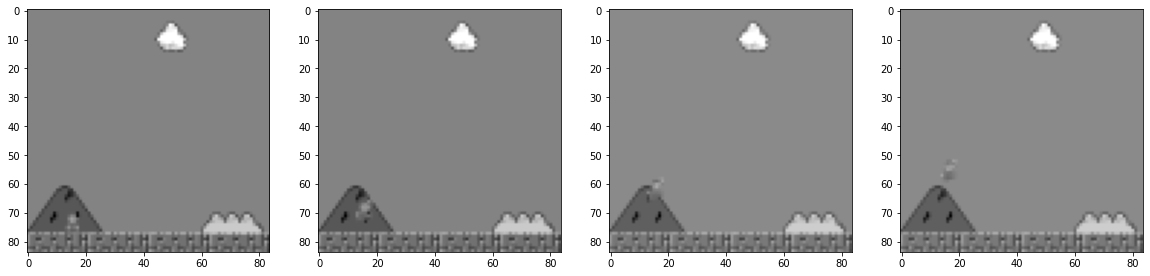

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

env.reset()
done = False

#Realizamos 3 acciones
state, reward, done, _ = env.step(env.action_space.sample()) # Ejecuta una acción aleatoria
state, reward, done, _ = env.step(env.action_space.sample())
state, reward, done, _ = env.step(env.action_space.sample()) 
print(f'Estado: {state.shape}, Recompensa: {reward}, Done: {done}')
ax[0].imshow(state[0], cmap='gray')
ax[1].imshow(state[1], cmap='gray')
ax[2].imshow(state[2], cmap='gray')
ax[3].imshow(state[3], cmap='gray')

plt.savefig(path_project + sep + 'reports' + sep + 'single_state.png', bbox_inches="tight")

Vamos a jugar con 5 episodios eligiendo todas las acciones aleatoriamente

In [22]:
play_random(env=env, episodes=5)

Episode: 1 -> Score: 61.39999999999999
Episode: 2 -> Score: 18.7
Episode: 3 -> Score: 63.60000000000016
Episode: 4 -> Score: 19.399999999999995
Episode: 5 -> Score: 66.5500000000002


## Double Deep Q Learning

Usaremos una red neuronal para aproximar la función que tiene como input una observación (4 imágenes en blanco y negro de 84x84 pixeles) y como output genera una acción. Para ello crearemos dos modelos. Es aquí donde viene el 'Double' en 'Double Deep Q Learning'. Uno de los modelos (model) se usará para predecir el valor de la tupla observación-estado, el otro modelo (target_model) se usara para calcular el target que según la ecuación de Bellman sera la recompensa obtenida mas el máximo valor de la siguiente observación futura por un factor de descuento. El modelo de predicción ira pasandole los pesos al modelo target cada cierto número de iteraciones.

La arquitectura del modelo sera muy similar al utilizado por la compañia DeepMind en su paper 'Playing Atari with Deep Reinforcement Learning'

<img src="../resources/target.png">

In [4]:
model = ConvNet(env.observation_space.shape, env.action_space.n) 
model.cuda()

target_model = ConvNet(env.observation_space.shape, env.action_space.n) 
target_model.cuda()

ConvNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

## Exploración vs predicción

Ya tenemos los modelos creados. No sería conveniente empezar a hacer predicciones directamente. Por ello introducimos el concepto de epsilon-greedy en nuestro modelo. Bajo este concepto al principio el agente realizara acciones aleatorias con una probabilidad cercana a 1, y a medida que vaya avanzando el número de observaciones esta probabilidad ira decayendo y la acciones empezarán a ser predichas por el modelo   

## Memory replay

Otro de los conceptos que vamos a utilizar para mejorar nuestro modelo es el memory replay. Esto consiste en ir guardando el estado actual, la acción realizada, la recompensa obtenida y el nuevo estado producto de la acción. En casa entrenamiento se pasará un subconjunto aleatorio de estos elementos guardados. Utilizaremos la colección deque de python para ir eliminando automáticamente los elementos mas viejos cuando se llegue al límite máximos de memoria establecido  

 ## Entrenamiento

Ahora vamos a establecer algunos de los hiperparámetros para el modelo y otros parámetros para el entrenamiento

In [18]:
episode = 1000

gamma_list = [0.95, 0.92, 0.97, 0.99, 1]
gamma = 0.95 # El factor de descuento. Determina cuanta importancia tienen las recompensas futuras

epsilon = 1
epsilon_minimun = 0.01
epsilon_decay_list = [0.999, 0.995, 0.99, 0.95, 0.9] #Cuanto mayor sea este número, la etapa de exploración durara más
epsilon_decay = 0.999

learning_rate_list= [0.0005, 0.1, 0.001, 0.0001, 0.00001]
learning_rate = 0.0005

state_memory = deque(maxlen=5000)
action_memory = deque(maxlen=5000)
reward_memory = deque(maxlen=5000)
new_state_memory = deque(maxlen=5000)
done_memory = deque(maxlen=5000)

frame_count = 0
score_list = pickle.load(open('../reports/score_list.h5', 'rb')) 
#score_list = [] Si empezamos de cero el entrenamiento
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

In [19]:
df = pd.DataFrame({'Modelo': ['Final', 'Prueba1', 'Prueba2', 'Prueba3', 'Prueba4'], 
        'learning_rate': learning_rate_list, 'gamma': gamma_list, 'epsilon_decay': epsilon_decay_list})
df.to_csv('../reports/df.csv', index=False)
df
# Resumen de nuestro modelo

,Modelo,learning_rate,gamma,epsilon_decay
0,Final,0.00050,0.95,0.999
1,Prueba1,0.10000,0.92,0.995
2,Prueba2,0.00100,0.97,0.990
3,Prueba3,0.00010,0.99,0.950
4,Prueba4,0.00001,1.00,0.900


In [21]:
score_episode = []
for i in range(5):
        epsilon = 1
        score_list_train = []

        model_train = ConvNet(env.observation_space.shape, env.action_space.n) 
        model_train.cuda()

        target_model_train = ConvNet(env.observation_space.shape, env.action_space.n) 
        target_model_train.cuda()  
        
        optimizer = torch.optim.Adam(model.parameters(), learning_rate_list[i])
        
        state_memory_train = deque(maxlen=500)
        action_memory_train = deque(maxlen=500)
        reward_memory_train = deque(maxlen=500)
        new_state_memory_train = deque(maxlen=500)
        done_memory_train = deque(maxlen=500)

        training(50, env, frame_count, model_train, target_model_train, epsilon, epsilon_decay_list[i],
                state_memory_train, action_memory_train, reward_memory_train, new_state_memory_train, done_memory_train,
                15, gamma_list[i], score_list_train, optimizer)

        score_episode.append(np.array(score_list_train).mean().item())
        print('score_episode: ', score_episode)

KeyboardInterrupt: 

In [12]:
score_episode

[29.999000000000002, 23.480499999999992]

In [ ]:
training(episode, env, frame_count, model, target_model, epsilon, epsilon_decay,
        state_memory, action_memory, reward_memory, new_state_memory, done_memory,
        batch_size, gamma, score_list, optimizer)


In [52]:
#pickle.dump(score_list, open('score_list.h5', 'wb'))
#torch.save(model.state_dict(), 'modelo_provisional.h5')
# Para guardar el score_list y el modelo entrenado

In [12]:
len(score_list)
# Hemos completado 650 episodios

650

Vamos a ver como avanza el score en cada episodio

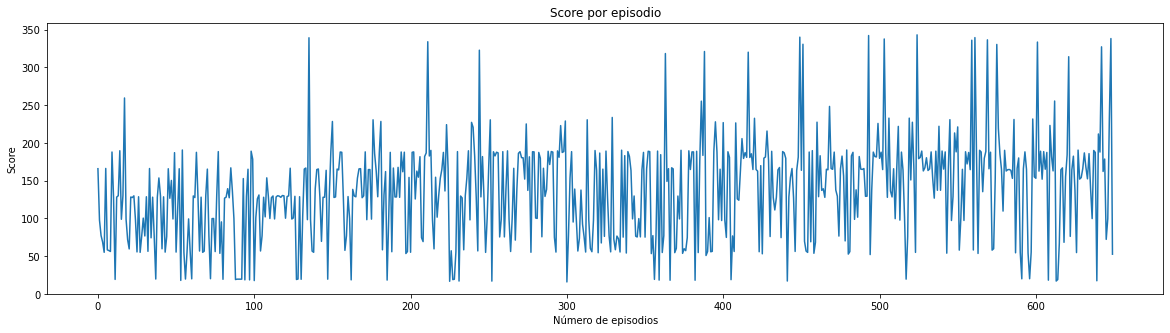

In [13]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([x for x in range(650)], score_list)
ax.set_xlabel('Número de episodios')
ax.set_ylabel('Score')
ax.set_title('Score por episodio')
plt.savefig(path_project + sep + 'reports' + sep + 'score.png', bbox_inches="tight")

Vemos que a medida que avanza, la densidad de episodios con mayor puntación aumenta. Para verlos mas claro haremos la media cada 10 episodios.

In [14]:
average_score = [sum(score_list[x: x+10])/10 for x in range(0, len(score_list), 10)]

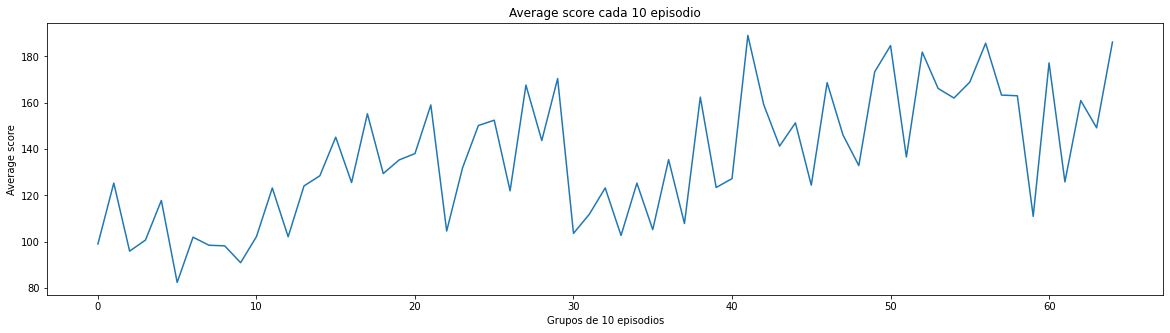

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([x for x in range(65)], average_score)
ax.set_xlabel('Grupos de 10 episodios')
ax.set_ylabel('Average score')
ax.set_title('Average score cada 10 episodio')
plt.savefig(path_project + sep + 'reports' + sep + 'score_average.png', bbox_inches="tight")

Cargamos el modelo ya entrenado y probamos como funciona

In [4]:
model_loaded = ConvNet(env.observation_space.shape, env.action_space.n) 
model_loaded.load_state_dict(torch.load(path_project + sep + 'models' + sep + 'model_supermario.h5'))
model_loaded.eval()


ConvNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [6]:
play(env=env, model=model_loaded)

Score:  340.19999999999897
